In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
TRG_df=pd.read_csv('/content/TRG.csv')
TLM_df=pd.read_csv('/content/TLM.csv')
SYN_df=pd.read_json('/content/SYN.json')
MAP_df=pd.read_csv('/content/MAP.csv')

In [3]:
# convert all timestamps to UTC - for uniformity
TLM_df['TIMESTAMP'] = pd.to_datetime(TLM_df['TIMESTAMP'], utc=True, errors='coerce')
TRG_df['CTS'] = pd.to_datetime(TRG_df['CTS'], utc=True, errors='coerce')
SYN_df['timestamp'] = pd.to_datetime(SYN_df['timestamp'], utc=True)

In [4]:
invalid_tlm = TLM_df[TLM_df['TIMESTAMP'].isnull() | TLM_df['VEHICLE_ID'].isnull()]
dupes = TLM_df.duplicated(subset=['VEHICLE_ID', 'TIMESTAMP'])
total_duplicates = dupes.sum()
total_rows = len(TLM_df)
print("Total number of rows:", total_rows)
print("Total number of duplicate rows:", total_duplicates)
print("percentage of duplicate rows:", total_duplicates/total_rows)

# Fix if small %: Drop or impute
# TLM_df = TLM_df.dropna(subset=['VEHICLE_ID', 'TIMESTAMP'])
# TLM_df = TLM_df[~dupes]

Total number of rows: 1833552
Total number of duplicate rows: 19945
percentage of duplicate rows: 0.010877793484995244


In [5]:
#since dataset has ~1% duplicate rows , we are in a managebale position, however we will check if they are exact duplicates

In [6]:
# 1. Find rows that have same VEHICLE_ID and TIMESTAMP
dupes = TLM_df.duplicated(subset=['VEHICLE_ID', 'TIMESTAMP'], keep=False)
dupe_rows = TLM_df[dupes]

# 2. Now check if these are exact duplicates across *all* columns
exact_dupes = dupe_rows.duplicated(keep=False)

# 3. Print the count
total_dupes = len(dupe_rows)
total_exact_dupes = exact_dupes.sum()
print(f"Total grouped duplicate rows: {total_dupes}")
print(f"Exact duplicates among them: {total_exact_dupes}")
print(f"Percentage of exact duplicates: {total_exact_dupes / total_dupes:.2%}")


Total grouped duplicate rows: 34533
Exact duplicates among them: 0
Percentage of exact duplicates: 0.00%


In [7]:
# Step 1: Get duplicate groups
dupes_mask = TLM_df.duplicated(subset=['VEHICLE_ID', 'TIMESTAMP'], keep=False)
dupe_rows = TLM_df[dupes_mask]

# Step 2: Calculate battery fluctuation range
battery_fluctuation = (
    dupe_rows.groupby(['VEHICLE_ID', 'TIMESTAMP'])['EV_BATTERY_LEVEL']
    .agg(['count', 'min', 'max'])
    .assign(range_diff=lambda df: df['max'] - df['min'])
)

# Step 3: Filter groups with abnormal fluctuation (e.g., >20%)
battery_anomalies = battery_fluctuation[battery_fluctuation['range_diff'] >= 0]

print(f"Total duplicate groups: {len(battery_fluctuation)}")
print(f"Anomalous battery fluctuation groups (>=0%): {len(battery_anomalies)}")
display(battery_anomalies.sort_values('range_diff', ascending=False).head(10))


Total duplicate groups: 14582
Anomalous battery fluctuation groups (>=0%): 3224


count  \
VEHICLE_ID                           TIMESTAMP                                 
fc86bd41-dd55-4d15-bb3f-35e31c7759e6 2023-01-30 20:48:45.352000+00:00      2   
026af092-a01e-4b0a-af38-f459725dabc6 2023-01-01 03:28:39.243000+00:00      2   
                                     2023-01-01 03:44:55.062000+00:00      2   
                                     2023-01-01 04:23:09.731000+00:00      2   
                                     2023-01-02 19:25:50.137000+00:00      2   
                                     2023-01-03 17:45:54.567000+00:00      2   
                                     2023-01-03 23:23:11.404000+00:00      2   
                                     2023-01-04 02:42:05.341000+00:00      2   
fc86bd41-dd55-4d15-bb3f-35e31c7759e6 2023-01-26 15:56:27.015000+00:00      2   
                                     2023-01-25 22:46:00.033000+00:00      2   

                                                                        min  \
VEHICLE_ID                           TIMESTAMP                                
fc86bd41-dd55-4d15-bb3f-35e31c7759e6 2023-01-30 20:48:45.352000+00:00  30.1   
026af092-a01e-4b0a-af38-f459725dabc6 2023-01-01 03:28:39.243000+00:00  70.0   
                                     2023-01-01 03:44:55.062000+00:00  65.0   
                                     2023-01-01 04:23:09.731000+00:00  62.0   
                                     2023-01-02 19:25:50.137000+00:00  47.0   
                                     2023-01-03 17:45:54.567000+00:00  60.0   
                                     2023-01-03 23:23:11.404000+00:00  58.0   
                                     2023-01-04 02:42:05.341000+00:00  58.0   
fc86bd41-dd55-4d15-bb3f-35e31c7759e6 2023-01-26 15:56:27.015000+00:00  52.1   
                                     2023-01-25 22:46:00.033000+00:00  47.8   

                                                                        max  \
VEHICLE_ID                           TIMESTAMP                                
fc86bd41-dd55-4d15-bb3f-35e31c7759e6 2023-01-30 20:48:45.352000+00:00  30.1   
026af092-a01e-4b0a-af38-f459725dabc6 2023-01-01 03:28:39.243000+00:00  70.0   
                                     2023-01-01 03:44:55.062000+00:00  65.0   
                                     2023-01-01 04:23:09.731000+00:00  62.0   
                                     2023-01-02 19:25:50.137000+00:00  47.0   
                                     2023-01-03 17:45:54.567000+00:00  60.0   
                                     2023-01-03 23:23:11.404000+00:00  58.0   
                                     2023-01-04 02:42:05.341000+00:00  58.0   
fc86bd41-dd55-4d15-bb3f-35e31c7759e6 2023-01-26 15:56:27.015000+00:00  52.1   
                                     2023-01-25 22:46:00.033000+00:00  47.8   

                                                                       range_diff  
VEHICLE_ID                           TIMESTAMP                                     
fc86bd41-dd55-4d15-bb3f-35e31c7759e6 2023-01-30 20:48:45.352000+00:00         0.0  
026af092-a01e-4b0a-af38-f459725dabc6 2023-01-01 03:28:39.243000+00:00         0.0  
                                     2023-01-01 03:44:55.062000+00:00         0.0  
                                     2023-01-01 04:23:09.731000+00:00         0.0  
                                     2023-01-02 19:25:50.137000+00:00         0.0  
                                     2023-01-03 17:45:54.567000+00:00         0.0  
                                     2023-01-03 23:23:11.404000+00:00         0.0  
                                     2023-01-04 02:42:05.341000+00:00         0.0  
fc86bd41-dd55-4d15-bb3f-35e31c7759e6 2023-01-26 15:56:27.015000+00:00         0.0  
                                     2023-01-25 22:46:00.033000+00:00         0.0

In [8]:
speed_fluctuation = (
    dupe_rows.groupby(['VEHICLE_ID', 'TIMESTAMP'])['SPEED']
    .agg(['count', 'min', 'max'])
    .assign(range_diff=lambda df: df['max'] - df['min'])
)

speed_anomalies = speed_fluctuation[speed_fluctuation['range_diff'] >= 50]
print(f"Anomalous battery fluctuation groups (>=0%): {len(speed_anomalies)}")
display(speed_anomalies.sort_values('range_diff', ascending=False).head(10))


Anomalous battery fluctuation groups (>=0%): 0


,,count,min,max,range_diff
VEHICLE_ID,TIMESTAMP,,,,


In [9]:
#3k out of 14.5k groups have any change at all -in

In [10]:
dupe_mask = TLM_df.duplicated(subset=['VEHICLE_ID', 'TIMESTAMP'], keep=False)
dupe_rows = TLM_df[dupe_mask]

# Step 2: Define aggregation logic
def mode(series):
    return series.mode().iloc[0] if not series.mode().empty else None

agg_funcs = {
    'SPEED': 'mean',
    'IGNITION_STATUS': mode,
    'EV_BATTERY_LEVEL': 'mean',
    'ODOMETER': 'max'
}

# Step 3: Group and aggregate
deduped = dupe_rows.groupby(['VEHICLE_ID', 'TIMESTAMP'], as_index=False).agg(agg_funcs)

# Step 4: Optional - combine with non-duplicate rows (to get back full dataset)
non_dupes = TLM_df[~dupe_mask]
cleaned_TLM_df = pd.concat([non_dupes, deduped], ignore_index=True)

#Sort by VEHICLE_ID and TIMESTAMP
cleaned_TLM_df = cleaned_TLM_df.sort_values(by=['VEHICLE_ID', 'TIMESTAMP']).reset_index(drop=True)



In [11]:
# Checking for any remaining duplicate keys
remaining_dupes = cleaned_TLM_df.duplicated(subset=['VEHICLE_ID', 'TIMESTAMP'], keep=False)
print("Remaining duplicates after aggregation:", remaining_dupes.sum())


Remaining duplicates after aggregation: 0


In [12]:
print(cleaned_TLM_df.isnull().sum())
missing_percent = cleaned_TLM_df.isnull().mean() * 100
print(missing_percent)
cleaned_TLM_df = cleaned_TLM_df.dropna(subset=['VEHICLE_ID', 'TIMESTAMP'])
#drop null values w timestamp

Unnamed: 0            14582
ID                    14582
VEHICLE_ID                0
TIMESTAMP                 2
SPEED               1466029
IGNITION_STATUS     1586139
EV_BATTERY_LEVEL    1430074
ODOMETER            1336121
dtype: int64
Unnamed: 0           0.804036
ID                   0.804036
VEHICLE_ID           0.000000
TIMESTAMP            0.000110
SPEED               80.835255
IGNITION_STATUS     87.457991
EV_BATTERY_LEVEL    78.852736
ODOMETER            73.672269
dtype: float64


In [13]:
missing_percent = cleaned_TLM_df.isnull().mean() * 100
print(missing_percent) #after dropping

Unnamed: 0           0.804037
ID                   0.804037
VEHICLE_ID           0.000000
TIMESTAMP            0.000000
SPEED               80.835234
IGNITION_STATUS     87.457977
EV_BATTERY_LEVEL    78.852712
ODOMETER            73.672240
dtype: float64


In [14]:
# Speed in km/h
invalid_speed = cleaned_TLM_df[(cleaned_TLM_df['SPEED'] < 0) | (cleaned_TLM_df['SPEED'] > 200)]
print("Invalid SPEED values:", len(invalid_speed))

# EV battery level in %
invalid_battery = cleaned_TLM_df[(cleaned_TLM_df['EV_BATTERY_LEVEL'] < 0) | (cleaned_TLM_df['EV_BATTERY_LEVEL'] > 100)]
print("Invalid EV_BATTERY_LEVEL values:", len(invalid_battery))

# Odometer in km
invalid_odometer = cleaned_TLM_df[cleaned_TLM_df['ODOMETER'] < 0]
print("Invalid ODOMETER values:", len(invalid_odometer))

# Ignition status must be ON/OFF or 1/0 (exclude nulls)
valid_ignition_set = ['ON', 'OFF', 1, 0]
invalid_ignition = cleaned_TLM_df[~cleaned_TLM_df['IGNITION_STATUS'].isin(valid_ignition_set) & ~cleaned_TLM_df['IGNITION_STATUS'].isna()]
print("Invalid IGNITION_STATUS values:", len(invalid_ignition))


Invalid SPEED values: 0
Invalid EV_BATTERY_LEVEL values: 1000
Invalid ODOMETER values: 0
Invalid IGNITION_STATUS values: 227462


In [15]:
# Replace invalid EV_BATTERY_LEVELs with NaN


# Fix IGNITION_STATUS to binary format if possible
# Map textual ON/OFF to 1/0
ignition_map = {'ON': 1, 'OFF': 0, 1: 1, 0: 0}
cleaned_TLM_df['IGNITION_STATUS_CLEANED'] = cleaned_TLM_df['IGNITION_STATUS'].map(ignition_map)

# Track how many couldn't be mapped (still NaN)
invalid_ignition_count = cleaned_TLM_df['IGNITION_STATUS_CLEANED'].isna().sum()
print(f"Unusable IGNITION_STATUS values: {invalid_ignition_count}")


Unusable IGNITION_STATUS values: 1813599


In [16]:
cleaned_TLM_df[cleaned_TLM_df['EV_BATTERY_LEVEL'] > 100].sort_values('EV_BATTERY_LEVEL', ascending=False).head()


,Unnamed: 0,ID,VEHICLE_ID,TIMESTAMP,SPEED,IGNITION_STATUS,EV_BATTERY_LEVEL,ODOMETER,IGNITION_STATUS_CLEANED
1628556,83861.0,9eeecd0b-5ff3-4aee-b173-d428217fb2a1,fc86bd41-dd55-4d15-bb3f-35e31c7759e6,2022-01-12 21:00:22.016000+00:00,NaN,NaN,110.0,NaN,NaN
60831,1071268.0,3bf8619f-d20b-4abc-952b-ff57866cac64,39424065-b3be-45e5-8f7d-b7f16a6c190a,2021-12-21 14:47:41.922000+00:00,NaN,NaN,110.0,57057.9,NaN
548892,799502.0,ef396b2c-c95a-4369-9098-7cffed90e43e,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-11-03 21:50:28+00:00,34.8,NaN,110.0,44381.9,NaN
1659247,635864.0,d9c732db-e155-4454-86f2-918d18c2b2e7,fc86bd41-dd55-4d15-bb3f-35e31c7759e6,2022-01-26 17:15:20.039000+00:00,NaN,NaN,110.0,NaN,NaN
545963,49932.0,f23d12be-db2e-45d4-9d08-f2aac4d07a81,66bd55df-eaf0-49c8-b9e1-7759b85e9325,2021-11-03 16:02:03.003000+00:00,NaN,NaN,110.0,44270.9,NaN


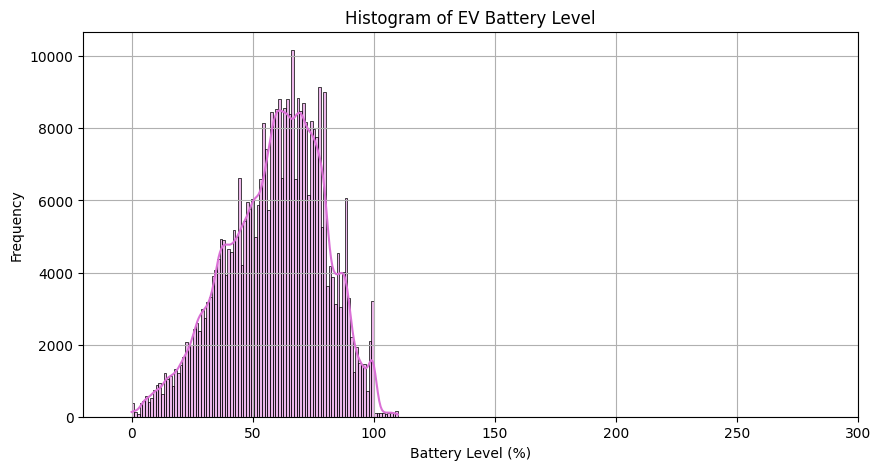

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(cleaned_TLM_df['EV_BATTERY_LEVEL'], bins=100, kde=True, color='orchid')

plt.title("Histogram of EV Battery Level")
plt.xlabel("Battery Level (%)")
plt.ylabel("Frequency")
plt.xlim(-20, 300)
plt.grid(True)
plt.show()


In [18]:
cleaned_TLM_df.loc[
    (cleaned_TLM_df['EV_BATTERY_LEVEL'] < 0) |
    (cleaned_TLM_df['EV_BATTERY_LEVEL'] > 100),
    'EV_BATTERY_LEVEL'
] = np.nan

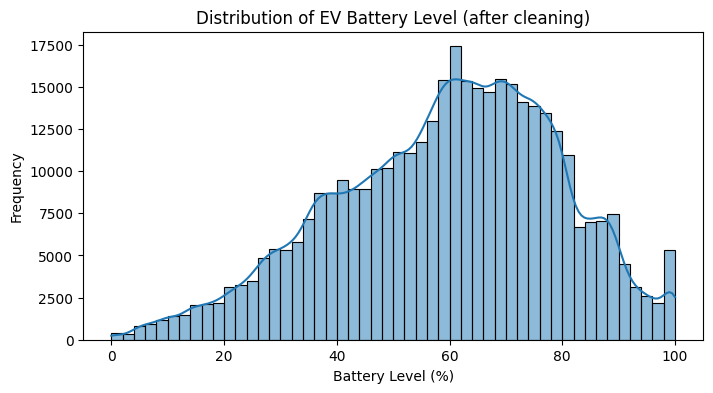

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(cleaned_TLM_df['EV_BATTERY_LEVEL'], bins=50, kde=True)
plt.title("Distribution of EV Battery Level (after cleaning)")
plt.xlabel("Battery Level (%)")
plt.ylabel("Frequency")
plt.show()


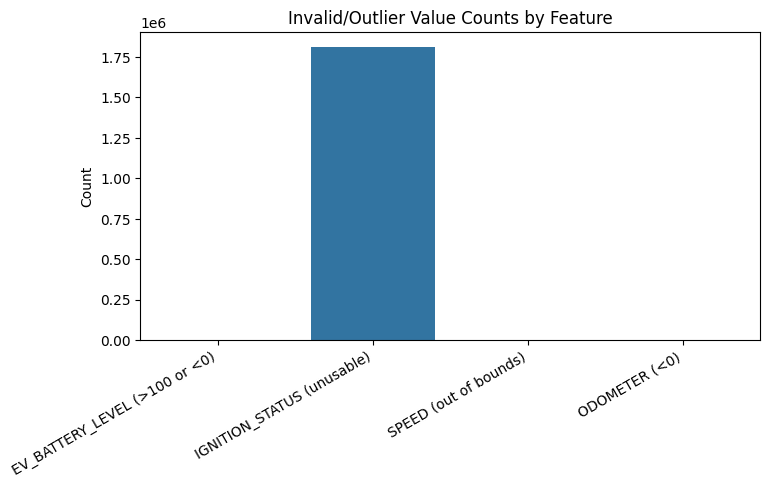

In [20]:
invalid_counts = {
    'EV_BATTERY_LEVEL (>100 or <0)': 1000,
    'IGNITION_STATUS (unusable)': invalid_ignition_count,
    'SPEED (out of bounds)': 0,
    'ODOMETER (<0)': 0,
}

plt.figure(figsize=(8, 4))
sns.barplot(x=list(invalid_counts.keys()), y=list(invalid_counts.values()))
plt.title("Invalid/Outlier Value Counts by Feature")
plt.ylabel("Count")
plt.xticks(rotation=30, ha='right')
plt.show()


In [21]:
#forward filling

In [22]:
# Clean up and normalize values
def normalize_ignition(val):
    if str(val).strip().upper() in ['ON', '1']:
        return 'ON'
    elif str(val).strip().upper() in ['OFF', '0']:
        return 'OFF'
    else:
        return np.nan

cleaned_TLM_df['IGNITION_STATUS_CLEANED'] = cleaned_TLM_df['IGNITION_STATUS'].apply(normalize_ignition)


In [23]:
# Sort by vehicle and time
cleaned_TLM_df.sort_values(by=['VEHICLE_ID', 'TIMESTAMP'], inplace=True)

# Forward fill
cleaned_TLM_df['IGNITION_STATUS_CLEANED'] = (
    cleaned_TLM_df.groupby('VEHICLE_ID')['IGNITION_STATUS_CLEANED']
    .ffill()
)


In [24]:
# Backfill if you want to fill starting NaNs too
cleaned_TLM_df['IGNITION_STATUS_CLEANED'] = (
    cleaned_TLM_df.groupby('VEHICLE_ID')['IGNITION_STATUS_CLEANED']
    .bfill()
)


In [25]:
print("Remaining NaNs in IGNITION_STATUS_CLEANED:",
      cleaned_TLM_df['IGNITION_STATUS_CLEANED'].isna().sum())

print("Distribution after cleaning:\n",
      cleaned_TLM_df['IGNITION_STATUS_CLEANED'].value_counts(dropna=False))


Remaining NaNs in IGNITION_STATUS_CLEANED: 178000
Distribution after cleaning:
 IGNITION_STATUS_CLEANED
ON     1594919
NaN     178000
OFF      40680
Name: count, dtype: int64


In [26]:
# Calculate odometer difference by vehicle
cleaned_TLM_df.sort_values(['VEHICLE_ID', 'TIMESTAMP'], inplace=True)
cleaned_TLM_df['ODOMETER_DIFF'] = cleaned_TLM_df.groupby('VEHICLE_ID')['ODOMETER'].diff()

# For NaN speed rows, check if odometer is moving
moving_with_no_speed = cleaned_TLM_df[cleaned_TLM_df['SPEED'].isna() & (cleaned_TLM_df['ODOMETER_DIFF'] > 0)]
print(f"Moving rows with missing SPEED: {len(moving_with_no_speed)}")


Moving rows with missing SPEED: 7605


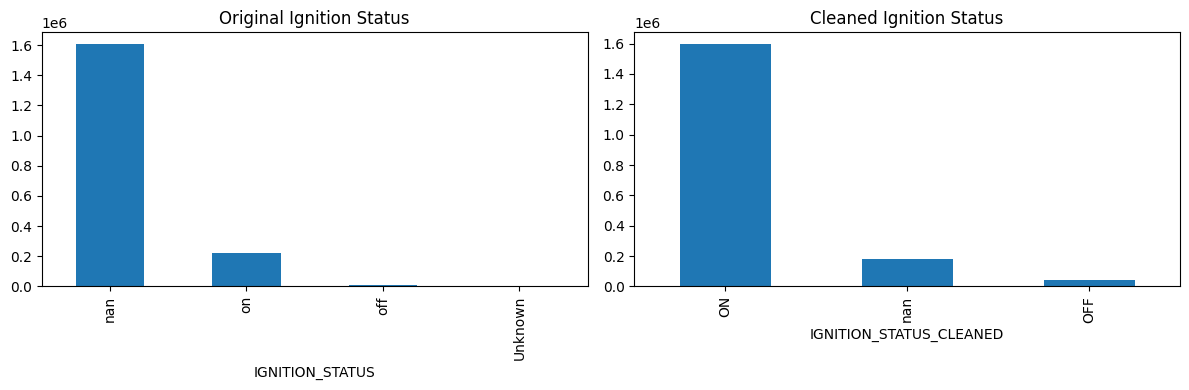

In [27]:
# Before cleaning
original_ignition = TLM_df['IGNITION_STATUS'].value_counts(dropna=False)
# After cleaning
cleaned_ignition = cleaned_TLM_df['IGNITION_STATUS_CLEANED'].value_counts(dropna=False)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
original_ignition.plot(kind='bar', ax=ax[0], title='Original Ignition Status')
cleaned_ignition.plot(kind='bar', ax=ax[1], title='Cleaned Ignition Status')
plt.tight_layout()
plt.show()


In [28]:
#FOCUSSING NOW ON THE TRG DATASET

In [29]:
print("Malformed timestamps:", TRG_df['CTS'].isna().sum())

Malformed timestamps: 0


In [30]:
# Unique values
print("IGN_CYL values:", TRG_df[TRG_df['NAME'] == 'IGN_CYL']['VAL'].unique())
print("CHARGE_STATE range:", TRG_df[TRG_df['NAME'] == 'CHARGE_STATE']['VAL'].astype(float).describe())
print("EV_CHARGE_STATE values:", TRG_df[TRG_df['NAME'] == 'EV_CHARGE_STATE']['VAL'].unique())


IGN_CYL values: ['OFF' 'ON']
CHARGE_STATE range: count    31367.000000
mean        58.487987
std         21.738038
min          0.000000
25%         42.700000
50%         60.300000
75%         75.200000
max        100.000000
Name: VAL, dtype: float64
EV_CHARGE_STATE values: ['Active' 'Aborted' 'Complete']


In [31]:
#binary
TRG_df['IGN_CYL_BINARY'] = TRG_df['VAL'].map({'OFF': 0, 'ON': 1})

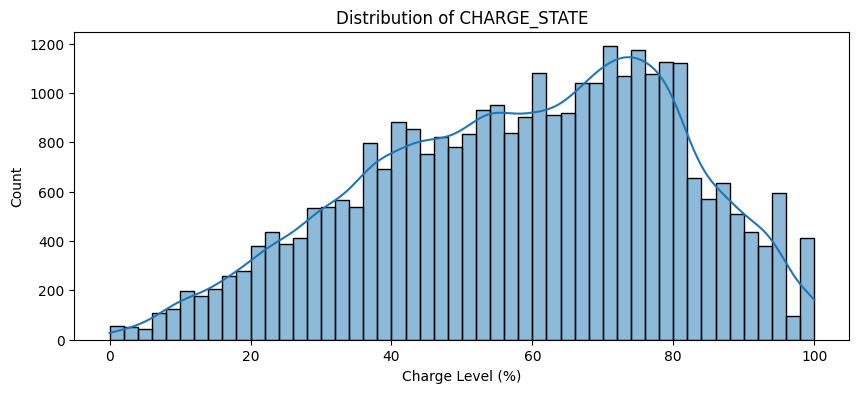

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

charge_vals = TRG_df[TRG_df['NAME'] == 'CHARGE_STATE']['VAL'].astype(float)

plt.figure(figsize=(10, 4))
sns.histplot(charge_vals, bins=50, kde=True)
plt.title("Distribution of CHARGE_STATE")
plt.xlabel("Charge Level (%)")
plt.show()



<Axes: title={'center': 'EV_CHARGE_STATE Distribution'}, xlabel='VAL'>

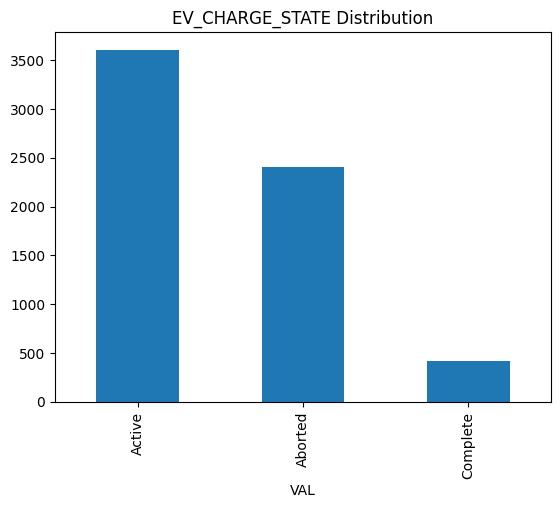

In [33]:
#ev-charge-state
ev_charge_state_counts = TRG_df[TRG_df['NAME'] == 'EV_CHARGE_STATE']['VAL'].value_counts()
ev_charge_state_counts.plot(kind='bar', title="EV_CHARGE_STATE Distribution")


In [34]:
ign_cyl_df = TRG_df[TRG_df['NAME'] == 'IGN_CYL'].copy()
charge_state_df = TRG_df[TRG_df['NAME'] == 'CHARGE_STATE'].copy()
ev_charge_state_df = TRG_df[TRG_df['NAME'] == 'EV_CHARGE_STATE'].copy()


In [35]:
#anomaly detecion column wise
ign_cyl_df['VAL'].value_counts(dropna=False)


,count
VAL,
OFF,15692
ON,15188


In [36]:
ign_cyl_df['VAL'].isna().sum()
print("🔍 Number of missing IGN_CYL values:", ign_cyl_df['VAL'].isna().sum())
print("\n📌 Sample rows with missing values:")
print(ign_cyl_df[ign_cyl_df['VAL'].isna()].head())


🔍 Number of missing IGN_CYL values: 0

📌 Sample rows with missing values:
Empty DataFrame
Columns: [Unnamed: 0, CTS, PNID, NAME, VAL, IGN_CYL_BINARY]
Index: []


In [37]:
#no anomaly here

In [38]:
charge_state_df['VAL'] = pd.to_numeric(charge_state_df['VAL'], errors='coerce')
invalid_charge_vals = charge_state_df[(charge_state_df['VAL'] < 0) | (charge_state_df['VAL'] > 100)]
print(invalid_charge_vals)
#no anomaly here


Empty DataFrame
Columns: [Unnamed: 0, CTS, PNID, NAME, VAL, IGN_CYL_BINARY]
Index: []


In [39]:
ev_charge_state_df['VAL'].value_counts(dropna=False)
valid_states = ['Active', 'Aborted', 'Complete']
ev_charge_state_df['VAL'] = ev_charge_state_df['VAL'].where(ev_charge_state_df['VAL'].isin(valid_states), np.nan)
print(ev_charge_state_counts)

VAL
Active      3607
Aborted     2401
Complete     415
Name: count, dtype: int64


In [40]:
ev_charge_state_df['VAL'].isna().sum()


np.int64(0)

In [41]:
state_mapping = {'Aborted': 0, 'Active': 1, 'Complete': 2}
ev_charge_state_df['EV_CHARGE_STATE_ENCODED'] = ev_charge_state_df['VAL'].map(state_mapping)


In [42]:
# 2nd Task

In [43]:
cleaned_TLM_df = cleaned_TLM_df.sort_values(['VEHICLE_ID', 'TIMESTAMP'])

# Forward fill to assume that status persists through missing values
cleaned_TLM_df['IGNITION_STATUS_CLEANED'] = (
    cleaned_TLM_df.groupby('VEHICLE_ID')['IGNITION_STATUS_CLEANED']
    .ffill()
)

# Detecting change
cleaned_TLM_df['prev_ign'] = cleaned_TLM_df.groupby('VEHICLE_ID')['IGNITION_STATUS_CLEANED'].shift(1)
ignition_change_df = cleaned_TLM_df[
    cleaned_TLM_df['IGNITION_STATUS_CLEANED'] != cleaned_TLM_df['prev_ign']
]


ignition_events = ignition_change_df[['VEHICLE_ID', 'IGNITION_STATUS_CLEANED', 'TIMESTAMP']].rename(
    columns={
        'VEHICLE_ID': 'vehicle_id',
        'IGNITION_STATUS_CLEANED': 'event',
        'TIMESTAMP': 'event_ts'
    }
)


ignition_events['event'] = ignition_events['event'].str.strip().str.upper()
ignition_events['event'] = ignition_events['event'].map({'ON': 'ignitionOn', 'OFF': 'ignitionOff'})
# Drop NaNs if any still remain
ignition_events = ignition_events.dropna(subset=['event'])

print(ignition_events.head())

                                 vehicle_id        event  \
31230  04105a12-59b9-447b-865f-599f48eed1d7   ignitionOn   
31277  04105a12-59b9-447b-865f-599f48eed1d7  ignitionOff   
31300  04105a12-59b9-447b-865f-599f48eed1d7   ignitionOn   
31356  04105a12-59b9-447b-865f-599f48eed1d7  ignitionOff   
99287  3bb48ce7-bb7e-4b4f-b902-b0561e1cd2e0   ignitionOn   

                              event_ts  
31230 2023-01-01 17:09:13.001000+00:00  
31277 2023-01-06 19:00:28.013000+00:00  
31300 2023-01-13 17:25:45.002000+00:00  
31356 2023-01-13 17:27:47.078000+00:00  
99287 2023-01-01 12:15:14.001000+00:00  


In [44]:
# Ensure CTS is datetime
TRG_df['CTS'] = pd.to_datetime(TRG_df['CTS'])

# Filter only ignition-related rows
ign_df = TRG_df[TRG_df['NAME'] == 'IGN_CYL'].copy()

# Keep only relevant columns
ign_df = ign_df[['CTS', 'PNID', 'VAL']].rename(columns={
    'CTS': 'event_ts',
    'PNID': 'vehicle_id',
    'VAL': 'event_raw'
})

# Sort by vehicle and time
ign_df = ign_df.sort_values(['vehicle_id', 'event_ts'])

# Detect ignition transitions (ON/OFF change)
ign_df['prev_event'] = ign_df.groupby('vehicle_id')['event_raw'].shift(1)
ign_transitions = ign_df[ign_df['event_raw'] != ign_df['prev_event']].copy()

# Normalize event names
ign_transitions['event'] = ign_transitions['event_raw'].map({
    'ON': 'ignitionOn',
    'OFF': 'ignitionOff'
})

# Final columns
trg_ignition_events = ign_transitions[['vehicle_id', 'event', 'event_ts']].reset_index(drop=True)

# Preview
print(trg_ignition_events.head())


   vehicle_id        event                  event_ts
0   186776160   ignitionOn 2021-09-04 00:01:16+00:00
1   186776160  ignitionOff 2021-09-04 00:15:40+00:00
2   186776160   ignitionOn 2021-09-04 00:23:16+00:00
3   186776160  ignitionOff 2021-09-04 00:27:13+00:00
4   186776160   ignitionOn 2021-09-04 18:42:41+00:00


In [45]:
import pandas as pd
import json

# Step 1: Clean and normalize ignition status
cleaned_TLM_df = cleaned_TLM_df.sort_values(by=['VEHICLE_ID', 'TIMESTAMP'])

cleaned_TLM_df['IGNITION_STATUS_CLEANED'] = (
    cleaned_TLM_df['IGNITION_STATUS']
    .astype(str)
    .str.upper()
    .where(cleaned_TLM_df['IGNITION_STATUS'].notna())
    .ffill()
)

# Step 2: Detect ignition transitions
cleaned_TLM_df['prev_ign'] = (
    cleaned_TLM_df.groupby('VEHICLE_ID')['IGNITION_STATUS_CLEANED']
    .shift(1)
)

valid_transitions = ['ON', 'OFF']
ignition_change_df = cleaned_TLM_df[
    (cleaned_TLM_df['IGNITION_STATUS_CLEANED'].isin(valid_transitions)) &
    (cleaned_TLM_df['prev_ign'].isin(valid_transitions)) &
    (cleaned_TLM_df['IGNITION_STATUS_CLEANED'] != cleaned_TLM_df['prev_ign'])
]

ignition_events_tlm = ignition_change_df[[
    'VEHICLE_ID', 'IGNITION_STATUS_CLEANED', 'TIMESTAMP'
]].rename(columns={
    'VEHICLE_ID': 'vehicle_id',
    'IGNITION_STATUS_CLEANED': 'event',
    'TIMESTAMP': 'event_ts'
})

ignition_events_tlm['event'] = ignition_events_tlm['event'].map({
    'ON': 'ignitionOn',
    'OFF': 'ignitionOff'
})


with open("SYN.json", "r") as f:
    syn_data = json.load(f)

syn_df = pd.DataFrame(syn_data)


syn_df = syn_df.rename(columns={
    "vehicleId": "vehicle_id",
    "timestamp": "event_ts",
    "type": "event"
})


syn_df['event_ts'] = pd.to_datetime(syn_df['event_ts'])



combined_events = pd.concat([
    ignition_events_tlm,
    syn_df[['vehicle_id', 'event', 'event_ts']]
], ignore_index=True)

# Sort by vehicle and timestamp
combined_events = combined_events.sort_values(by=['vehicle_id', 'event_ts']).reset_index(drop=True)

print(combined_events.head())


                             vehicle_id             event  \
0  04105a12-59b9-447b-865f-599f48eed1d7       ignitionOff   
1  04105a12-59b9-447b-865f-599f48eed1d7        ignitionOn   
2  04105a12-59b9-447b-865f-599f48eed1d7       ignitionOff   
3  19c4f06a-d5c7-4e51-ae2c-56c5367c0d50  artificial_event   
4  19c4f06a-d5c7-4e51-ae2c-56c5367c0d50  artificial_event   

                          event_ts  
0 2023-01-06 19:00:28.013000+00:00  
1 2023-01-13 17:25:45.002000+00:00  
2 2023-01-13 17:27:47.078000+00:00  
3 2021-12-19 07:31:53.009000+00:00  
4 2021-12-19 18:33:46.004000+00:00  


In [46]:
# Filter relevant charging state events from both EV_CHARGE_STATE
charging_events_df = TRG_df[
    (TRG_df['NAME'].isin(['EV_CHARGE_STATE'])) &
    (TRG_df['VAL'].isin(['Active', 'Aborted', 'Complete']))

].copy()

# Rename and select only relevant columns
charging_events_df = charging_events_df.rename(columns={
    'PNID': 'vehicle_id',
    'VAL': 'event',
    'CTS': 'event_ts'
})[['vehicle_id', 'event', 'event_ts']].reset_index(drop=True)

# Sort by vehicle and timestamp
charging_events_df.sort_values(by=['vehicle_id', 'event_ts'], inplace=True)


#print(charging_events_df.to_string(index=False))
# Print a few examples of each event type
print("\nSample Active Events:")
print(charging_events_df[charging_events_df['event'] == 'Active'].head(5).to_string(index=False))

print("\nSample Abort Events:")
print(charging_events_df[charging_events_df['event'] == 'Aborted'].head(5).to_string(index=False))
print("\nSample Complete Events:")
print(charging_events_df[charging_events_df['event'] == 'Complete'].head(5).to_string(index=False))





Sample Active Events:
 vehicle_id  event                  event_ts
  186776160 Active 2022-01-12 19:06:49+00:00
  186776160 Active 2022-01-12 19:06:49+00:00
  186776160 Active 2022-01-12 19:31:32+00:00
  186776160 Active 2022-01-12 19:31:32+00:00
  186776160 Active 2022-01-12 20:07:49+00:00

Sample Abort Events:
 vehicle_id   event                  event_ts
  186776160 Aborted 2022-01-12 19:31:01+00:00
  186776160 Aborted 2022-01-12 19:31:01+00:00
  186776160 Aborted 2022-01-12 20:03:02+00:00
  186776160 Aborted 2022-01-12 20:03:02+00:00
  186776160 Aborted 2022-01-12 20:18:34+00:00

Sample Complete Events:
 vehicle_id    event                  event_ts
  186776160 Complete 2022-01-16 22:26:54+00:00
  186776160 Complete 2022-01-16 22:26:54+00:00
  186776160 Complete 2022-01-18 08:32:07+00:00
  186776160 Complete 2022-01-18 08:32:07+00:00
  186776160 Complete 2022-01-21 16:41:31+00:00


In [47]:
import duckdb

# Connect to DuckDB in-memory
con = duckdb.connect()

# Register the cleaned_TLM_df pandas DataFrame as a DuckDB table
con.register('battery_df', cleaned_TLM_df)

# Run a simple query to check data and connection
result = con.execute("""
    SELECT VEHICLE_ID, COUNT(*) AS row_count
    FROM battery_df
    GROUP BY VEHICLE_ID
    LIMIT 5
""").df()

print(result)


                             VEHICLE_ID  row_count
0  39424065-b3be-45e5-8f7d-b7f16a6c190a      67906
1  66bd55df-eaf0-49c8-b9e1-7759b85e9325     497137
2  8ce8b281-3c5e-4b17-a863-630b9fc813dc      49764
3  9893c80d-f282-46cf-a794-280f0306c936     142005
4  fc86bd41-dd55-4d15-bb3f-35e31c7759e6     589495


In [54]:
# import duckdb
# import pandas as pd

# # ---------- Step 1: Prepare event DataFrames ----------

# # Assuming these are your ignition and charging event DataFrames:
# # ignition_events_df, charging_events_df are already in correct format:
# # columns: ['vehicle_id', 'event_ts', 'event_type']

# # Prepare charge_state_df from TRG_df filtering 'CHARGE_STATE' events
# charge_state_df = TRG_df[TRG_df['NAME'] == 'CHARGE_STATE'].copy()

# # Rename columns to match others
# charge_state_df = charge_state_df.rename(columns={
#     'VEHICLE_ID': 'vehicle_id',
#     'TIMESTAMP': 'event_ts'
# })

# # Convert timestamp column to datetime
# charge_state_df['event_ts'] = pd.to_datetime(charge_state_df['event_ts'])

# # Assign event_type to charge_state events
# charge_state_df['event_type'] = 'charging'

# # ---------- Step 2: Combine all events ----------

# combined_events_df = pd.concat([
#     ignition_events[['vehicle_id', 'event_ts', 'event_type']],
#     charging_events_df[['vehicle_id', 'event_ts', 'event_type']],
#     charge_state_df[['vehicle_id', 'event_ts', 'event_type']]
# ], ignore_index=True)

# # ---------- Step 3: Prepare cleaned_TLM_df for battery lookup ----------

# # Make sure cleaned_TLM_df timestamps are datetime and columns are correctly named
# cleaned_TLM_df['TIMESTAMP'] = pd.to_datetime(cleaned_TLM_df['TIMESTAMP'])

# # ---------- Step 4: Register tables in DuckDB ----------

# con = duckdb.connect()

# con.register('battery_df', cleaned_TLM_df)
# con.register('events_df', combined_events_df)

# # ---------- Step 5: Query to associate battery level within ±300s of event ----------

# query = """
# SELECT
#     e.vehicle_id,
#     e.event_ts,
#     e.event_type,
#     b.EV_BATTERY_LEVEL AS battery_level
# FROM events_df e
# LEFT JOIN LATERAL (
#     SELECT EV_BATTERY_LEVEL, TIMESTAMP,
#            ABS(EXTRACT(EPOCH FROM (e.event_ts - TIMESTAMP))) AS time_diff,
#            CASE
#                WHEN TIMESTAMP >= e.event_ts THEN 0  -- prefer later reading if tie
#                ELSE 1
#            END AS prefer_earlier
#     FROM battery_df b
#     WHERE b.VEHICLE_ID = e.vehicle_id
#       AND b.TIMESTAMP BETWEEN e.event_ts - INTERVAL '300 seconds' AND e.event_ts + INTERVAL '300 seconds'
#     ORDER BY time_diff ASC, prefer_earlier ASC
#     LIMIT 1
# ) b ON TRUE
# ORDER BY e.vehicle_id, e.event_ts
# """

# # ---------- Step 6: Execute query ----------

# battery_enriched_events = con.execute(query).df()

# print(battery_enriched_events.head(10))


In [56]:
# import pandas as pd
# import duckdb

# # --- Step 0: Assume these DataFrames are loaded in your environment ---
# # ignition_events: columns = ['vehicle_id', 'event_ts', 'event_type']
# # charging_events_df: columns = ['vehicle_id', 'event_ts', 'event_type']
# # TRG_df: your trigger data frame with at least ['VEHICLE_ID', 'TIMESTAMP', 'NAME'] columns
# # cleaned_TLM_df: telemetry data with ['VEHICLE_ID', 'TIMESTAMP', 'EV_BATTERY_LEVEL', ...] columns

# # --- Step 1: Prepare charge_state_df from TRG_df ---

# charge_state_df = TRG_df[TRG_df['NAME'] == 'CHARGE_STATE'].copy()

# charge_state_df = charge_state_df.rename(columns={
#     'VEHICLE_ID': 'vehicle_id',
#     'TIMESTAMP': 'event_ts'
# })
# combined_events_df = pd.concat([
#     combined_events[['vehicle_id', 'event_ts', 'event_type']],
#     charging_events_df[['vehicle_id', 'event_ts', 'event_type']],
# ], ignore_index=True)



In [50]:
# # --- Step 4: Prepare cleaned_TLM_df battery data ---

# cleaned_TLM_df['TIMESTAMP'] = pd.to_datetime(cleaned_TLM_df['TIMESTAMP'])

# # Check columns, rename if needed for DuckDB (case-sensitive)
# # DuckDB query references battery_df.VEHICLE_ID and battery_df.TIMESTAMP so:
# cleaned_TLM_df = cleaned_TLM_df.rename(columns={
#     'VEHICLE_ID': 'VEHICLE_ID',
#     'TIMESTAMP': 'TIMESTAMP',
#     'EV_BATTERY_LEVEL': 'EV_BATTERY_LEVEL'
# })

# # --- Step 5: Register DataFrames in DuckDB ---

# con = duckdb.connect()

# con.register('battery_df', cleaned_TLM_df)
# con.register('events_df', combined_events_df)



# query = """
# SELECT
#     e.vehicle_id,
#     e.event_ts,
#     e.event_type,
#     b.EV_BATTERY_LEVEL AS battery_level
# FROM events_df e
# LEFT JOIN LATERAL (
#     SELECT EV_BATTERY_LEVEL, TIMESTAMP,
#            ABS(EXTRACT(EPOCH FROM (e.event_ts - TIMESTAMP))) AS time_diff,
#            CASE
#                WHEN TIMESTAMP >= e.event_ts THEN 0  -- prefer later reading if tie
#                ELSE 1
#            END AS prefer_earlier
#     FROM battery_df b
#     WHERE b.VEHICLE_ID = e.vehicle_id
#       AND b.TIMESTAMP BETWEEN e.event_ts - INTERVAL '300 seconds' AND e.event_ts + INTERVAL '300 seconds'
#     ORDER BY time_diff ASC, prefer_earlier ASC
#     LIMIT 1
# ) b ON TRUE
# ORDER BY e.vehicle_id, e.event_ts
# """

# battery_enriched_events = con.execute(query).df()

# # --- Step 7: Show result ---

# print(battery_enriched_events.head(12))


In [51]:
import pandas as pd
import duckdb

# --- Step 1: Load MAP.csv and join with events to resolve ID mismatch ---

map_df = pd.read_csv("MAP.csv")  # Ensure MAP.csv contains at least `vehicle_id`, `PNID` or similar mapping

# Rename for clarity
map_df = map_df.rename(columns={'ID': 'vehicle_id', 'IDS': 'pnid'})

# Join mapping to events dataframe
combined_events_df = combined_events_df.merge(
    map_df[['vehicle_id', 'pnid']],  # keep only relevant cols
    on='vehicle_id',
    how='left'
)


# Replace UUIDs with mapped PNIDs (or keep both, depending on need)
combined_events_df['mapped_vehicle_id'] = combined_events_df['pnid']


# Drop rows where mapping failed
combined_events_df = combined_events_df.dropna(subset=['mapped_vehicle_id'])

# --- Step 2: Clean battery (TLM) data ---

cleaned_TLM_df['TIMESTAMP'] = pd.to_datetime(cleaned_TLM_df['TIMESTAMP'])

# Ensure battery_df columns are in correct format
cleaned_TLM_df = cleaned_TLM_df.rename(columns={
    'VEHICLE_ID': 'VEHICLE_ID',
    'TIMESTAMP': 'TIMESTAMP',
    'EV_BATTERY_LEVEL': 'EV_BATTERY_LEVEL'
})

# --- Step 3: Register DataFrames in DuckDB ---

con = duckdb.connect()
con.register('battery_df', cleaned_TLM_df)
con.register('events_df', combined_events_df)

# --- Step 4: Run enriched battery join with ±300s window ---

query = """
SELECT
    e.vehicle_id,
    e.event_ts,
    e.event_type,
    b.EV_BATTERY_LEVEL AS battery_level
FROM events_df e
LEFT JOIN LATERAL (
    SELECT EV_BATTERY_LEVEL, TIMESTAMP,
           ABS(EXTRACT(EPOCH FROM (e.event_ts - TIMESTAMP))) AS time_diff,
           CASE
               WHEN TIMESTAMP >= e.event_ts THEN 0
               ELSE 1
           END AS prefer_earlier
    FROM battery_df b
    WHERE b.VEHICLE_ID = e.mapped_vehicle_id
      AND b.TIMESTAMP BETWEEN e.event_ts - INTERVAL '300 seconds' AND e.event_ts + INTERVAL '300 seconds'
    ORDER BY time_diff ASC, prefer_earlier ASC
    LIMIT 1
) b ON TRUE
ORDER BY e.vehicle_id, e.event_ts
"""

battery_enriched_events = con.execute(query).df()

# --- Step 5: Show result ---

print(battery_enriched_events.head(12))


NameError: name 'combined_events_df' is not defined

In [ ]:
import pandas as pd
import duckdb

# --- Step 1: Load and inspect MAP.csv ---
map_df = pd.read_csv("MAP.csv")
print("MAP.csv loaded:", map_df.head())

# Rename columns for clarity and consistency
map_df = map_df.rename(columns={'ID': 'vehicle_id', 'IDS': 'pnid'})
print("Renamed MAP columns:", map_df.columns)

# --- Step 2: Extract ignition events from TRG ---
TRG_df = pd.read_csv("TRG.csv")
print("TRG_df loaded:", TRG_df.head())

ign_df = TRG_df[TRG_df['NAME'] == 'IGN_CYL'].copy()
ign_df['event_type'] = 'ignition'
print("Columns in ign_df:", ign_df.columns.tolist())
print("Sample rows:\n", ign_df.head())

ign_df['event_ts'] = pd.to_datetime(ign_df['CTS'])

ign_df = ign_df.rename(columns={'PNID': 'pnid'})
print("Ignition events extracted:", ign_df[['pnid', 'event_ts']].head())
# Make sure both pnid columns are strings
ign_df['pnid'] = ign_df['pnid'].astype(str)
map_df['pnid'] = map_df['pnid'].astype(str)

# Now perform the merge
ignition_events = ign_df.merge(map_df, on='pnid', how='left')

# Show sample results
print("After joining MAP:", ignition_events[['vehicle_id', 'pnid', 'event_ts']].head())


# --- Step 3: Join MAP with ignition events ---
ignition_events = ign_df.merge(map_df, on='pnid', how='left')
print("After joining MAP:", ignition_events[['vehicle_id', 'pnid', 'event_ts']].head())

# Drop rows with missing vehicle IDs
ignition_events = ignition_events.dropna(subset=['vehicle_id'])
print("After dropping missing vehicle_ids:", ignition_events.shape)

# --- Step 4: Rename for final use ---
ignition_events = ignition_events.rename(columns={'vehicle_id': 'mapped_vehicle_id'})

cleaned_TLM_df['TIMESTAMP'] = pd.to_datetime(cleaned_TLM_df['TIMESTAMP'], format='mixed', errors='coerce')
cleaned_TLM_df = cleaned_TLM_df.rename(columns={
    'VEHICLE_ID': 'VEHICLE_ID',
    'TIMESTAMP': 'TIMESTAMP',
    'EV_BATTERY_LEVEL': 'EV_BATTERY_LEVEL'
})
print("Cleaned TLM DataFrame:", cleaned_TLM_df.head())

# --- Step 6: Register in DuckDB ---
con = duckdb.connect()
con.register('battery_df', cleaned_TLM_df)
con.register('events_df', ignition_events)

# --- Step 7: Enrich ignition events with battery level from TLM (±300s) ---
query = """
SELECT
    e.mapped_vehicle_id AS vehicle_id,
    e.event_ts,
    e.event_type,
    b.EV_BATTERY_LEVEL AS battery_level
FROM events_df e
LEFT JOIN LATERAL (
    SELECT
        EV_BATTERY_LEVEL,
        TIMESTAMP,
        ABS(EXTRACT(EPOCH FROM (
            CAST(e.event_ts AS TIMESTAMP) - CAST(b.TIMESTAMP AS TIMESTAMP)
        ))) AS time_diff,
        CASE
            WHEN CAST(b.TIMESTAMP AS TIMESTAMP) >= CAST(e.event_ts AS TIMESTAMP) THEN 0
            ELSE 1
        END AS prefer_earlier
    FROM battery_df b
    WHERE b.VEHICLE_ID = e.mapped_vehicle_id
      AND CAST(b.TIMESTAMP AS TIMESTAMP)
          BETWEEN CAST(e.event_ts AS TIMESTAMP) - INTERVAL '300 seconds'
              AND CAST(e.event_ts AS TIMESTAMP) + INTERVAL '300 seconds'
    ORDER BY time_diff ASC, prefer_earlier ASC
    LIMIT 1
) b ON TRUE
ORDER BY e.mapped_vehicle_id, e.event_ts

"""

battery_enriched_events = con.execute(query).df()

# --- Step 8: Display final result ---
print("\nFinal battery-enriched ignition events:")
print(battery_enriched_events.head(24))


In [57]:
import pandas as pd
import duckdb
import ast

# --- Step 1: Load and correctly process MAP.csv ---
map_df = pd.read_csv("MAP.csv")
print("MAP.csv loaded.")

map_df = map_df.rename(columns={'ID': 'vehicle_id', 'IDS': 'pnid_list_str'})
map_df.dropna(subset=['pnid_list_str'], inplace=True)

def parse_pnid_list(s):
    try:
        return ast.literal_eval(s.replace('\n', ''))
    except (ValueError, SyntaxError):
        return []

map_df['pnid_list'] = map_df['pnid_list_str'].apply(parse_pnid_list)
map_exploded_df = map_df.explode('pnid_list')
map_clean_df = map_exploded_df[['vehicle_id', 'pnid_list']].rename(columns={'pnid_list': 'pnid'})
map_clean_df.dropna(subset=['pnid'], inplace=True)
print("MAP data cleaned and exploded for proper joining.")


# --- Step 2: Extract ignition events from TRG.csv ---
trg_df = pd.read_csv("TRG.csv")
print("\nTRG.csv loaded.")

ign_df = trg_df[trg_df['NAME'] == 'IGN_CYL'].copy()
ign_df['event_type'] = 'ignition'
ign_df['event_ts'] = pd.to_datetime(ign_df['CTS'], format='mixed', errors='coerce')
ign_df.dropna(subset=['event_ts'], inplace=True)
ign_df = ign_df.rename(columns={'PNID': 'pnid'})

ign_df['pnid'] = ign_df['pnid'].astype(str)
map_clean_df['pnid'] = map_clean_df['pnid'].astype(str)
print("Ignition events extracted from TRG.csv.")


# --- Step 3: Join MAP with ignition events to get vehicle_id ---
ignition_events = ign_df.merge(map_clean_df, on='pnid', how='left')

initial_count = len(ignition_events)
ignition_events.dropna(subset=['vehicle_id'], inplace=True)
print(f"\nSuccessfully mapped {len(ignition_events)} events to a vehicle_id.")
print(f"Dropped {initial_count - len(ignition_events)} unmappable events.")


# --- Step 4: Load and clean telemetry data (assuming TLM.csv) ---
try:
    tlm_df = pd.read_csv("TLM.csv")
    print("\nTLM.csv loaded.")

    battery_df = tlm_df[['VEHICLE_ID', 'TIMESTAMP', 'EV_BATTERY_LEVEL']].copy()
    battery_df.dropna(inplace=True)
    battery_df['TIMESTAMP'] = pd.to_datetime(battery_df['TIMESTAMP'], format='mixed', errors='coerce')
    battery_df.dropna(subset=['TIMESTAMP'], inplace=True)
    print("Cleaned TLM DataFrame ready for use.")

    # --- Step 5: Register DataFrames in DuckDB for querying ---
    con = duckdb.connect(database=':memory:')
    events_df = ignition_events[['vehicle_id', 'event_ts', 'event_type']].drop_duplicates()
    con.register('events_df', events_df)
    con.register('battery_df', battery_df)
    print("\nRegistered DataFrames in DuckDB.")

    # --- Step 6: Enrich ignition events with the closest battery level (FIXED QUERY) ---
    # We cast `e.event_ts` to TIMESTAMP to match the type of `b.TIMESTAMP`, resolving the error.
    query = """
    SELECT
        e.vehicle_id,
        e.event_ts,
        e.event_type,
        b.battery_level
    FROM events_df AS e
    LEFT JOIN LATERAL (
        SELECT
            b.EV_BATTERY_LEVEL AS battery_level
        FROM battery_df AS b
        WHERE
            -- Match on the same vehicle
            b.VEHICLE_ID = e.vehicle_id
            -- Filter to the +/- 300 second time window, casting the event time to a naive timestamp
            AND b.TIMESTAMP BETWEEN (CAST(e.event_ts AS TIMESTAMP) - INTERVAL '300 seconds')
                                AND (CAST(e.event_ts AS TIMESTAMP) + INTERVAL '300 seconds')
        ORDER BY
            -- 1st: Sort by the smallest time difference (casting for the calculation)
            ABS(EXTRACT(EPOCH FROM (CAST(e.event_ts AS TIMESTAMP) - b.TIMESTAMP))) ASC,
            -- 2nd: Tie-breaker - prefer readings AT or AFTER the event (casting for the comparison)
            CASE WHEN b.TIMESTAMP >= CAST(e.event_ts AS TIMESTAMP) THEN 0 ELSE 1 END ASC
        LIMIT 1
    ) AS b ON TRUE
    ORDER BY
        e.vehicle_id, e.event_ts
    """

    battery_enriched_events = con.execute(query).df()

    # --- Step 7: Display final result ---
    print("\nFinal battery-enriched ignition events:")
    print(battery_enriched_events.to_string())

except FileNotFoundError:
    print("\nERROR: `TLM.csv` not found. Please ensure the telemetry data file is in the same directory.")

MAP.csv loaded.
MAP data cleaned and exploded for proper joining.

TRG.csv loaded.
Ignition events extracted from TRG.csv.

Successfully mapped 11679 events to a vehicle_id.
Dropped 21031 unmappable events.

TLM.csv loaded.
Cleaned TLM DataFrame ready for use.

Registered DataFrames in DuckDB.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Streaming output truncated to the last 5000 lines.
3286  9893c80d-f282-46cf-a794-280f0306c936 2021-09-29 04:08:56+00:00   ignition            NaN
3287  9893c80d-f282-46cf-a794-280f0306c936 2021-09-29 04:11:32+00:00   ignition            NaN
3288  9893c80d-f282-46cf-a794-280f0306c936 2021-09-29 04:29:24+00:00   ignition            NaN
3289  9893c80d-f282-46cf-a794-280f0306c936 2021-09-29 04:37:33+00:00   ignition            NaN
3290  9893c80d-f282-46cf-a794-280f0306c936 2021-09-29 04:45:24+00:00   ignition            NaN
3291  9893c80d-f282-46cf-a794-280f0306c936 2021-09-29 04:49:19+00:00   ignition            NaN
3292  9893c80d-f282-46cf-a794-280f0306c936 2021-09-29 04:59:25+00:00   ignition            NaN
3293  9893c80d-f282-46cf-a794-280f0306c936 2021-09-29 05:19:29+00:00   ignition            NaN
3294  9893c80d-f282-46cf-a794-280f0306c936 2021-09-29 05:21:01+00:00   ignition            NaN
3295  9893c80d-f282-46cf-a794-280f0306c936 2021-09-29 05:28:13+00:00   ignition            NaN

In [58]:
def detect_charging_events(df, off_threshold=3, on_threshold=6, debounce_minutes=15):
    import pandas as pd

    df = df.sort_values(by=['vehicle_id', 'event_ts']).reset_index(drop=True)
    df['battery_level'] = df['battery_level'].astype(float)

    charging_events = []
    last_vehicle, last_level, last_ts, session_start = None, None, None, None

    for idx, row in df.iterrows():
        vehicle = row['vehicle_id']
        ts = row['event_ts']
        level = row['battery_level']
        ignition = row.get('ignition_state') or row.get('event_type', 'UNKNOWN')

        if pd.isnull(level) or pd.isnull(ts):
            continue

        if last_vehicle != vehicle:
            last_vehicle, last_level, last_ts, session_start = vehicle, level, ts, ts
            continue

        level_diff = level - last_level
        time_diff = (ts - last_ts).total_seconds() / 60  # in minutes

        if level_diff > 0:
            # Choose threshold based on ignition
            threshold = on_threshold if ignition == "ON" else off_threshold
            if level_diff >= threshold:
                # New session if enough time has passed
                if (ts - session_start).total_seconds() / 60 > debounce_minutes:
                    charging_events.append({
                        'vehicle_id': vehicle,
                        'start_ts': last_ts,
                        'end_ts': ts,
                        'start_battery': last_level,
                        'end_battery': level,
                        'battery_jump': level_diff,
                        'ignition_state': ignition
                    })
                    session_start = ts

        last_level = level
        last_ts = ts

    return pd.DataFrame(charging_events)


In [59]:
charging_df = detect_charging_events(battery_enriched_events)
print("Detected charging events:")
print(charging_df.head())

Detected charging events:
                             vehicle_id                  start_ts  \
0  66bd55df-eaf0-49c8-b9e1-7759b85e9325 2021-09-18 02:16:29+00:00   
1  66bd55df-eaf0-49c8-b9e1-7759b85e9325 2021-09-23 15:18:05+00:00   
2  66bd55df-eaf0-49c8-b9e1-7759b85e9325 2021-09-25 05:03:00+00:00   
3  66bd55df-eaf0-49c8-b9e1-7759b85e9325 2021-09-27 03:06:29+00:00   
4  66bd55df-eaf0-49c8-b9e1-7759b85e9325 2021-10-02 15:11:12+00:00   

                     end_ts  start_battery  end_battery  battery_jump  \
0 2021-09-18 02:31:48+00:00          101.0        108.0           7.0   
1 2021-09-25 02:10:44+00:00           21.1         78.4          57.3   
2 2021-09-25 16:40:40+00:00           63.9         80.7          16.8   
3 2021-10-02 02:13:59+00:00           49.4         76.0          26.6   
4 2021-10-02 17:13:50+00:00           39.2         75.2          36.0   

  ignition_state  
0       ignition  
1       ignition  
2       ignition  
3       ignition  
4       ignition  


In [ ]:
print(charging_events_df.columns)
print(combined_events.columns)
print(trg_ignition_events.columns)
print(ignition_events.columns)
print(charge_state_df.columns)
print(cleaned_TLM_df.columns)


In [ ]:
print("ignition_events columns:", ignition_events.columns)
print("charging_events_df columns:", charging_events_df.columns)
print("charge_state_df columns:", charge_state_df.columns)
